In [1]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [2]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
mp_drawing = mp.solutions.drawing_utils 

In [3]:
def detectPose(image, pose, display=True):
    output_image = image.copy()
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    results = pose.process(imageRGB)
    height, width, _ = image.shape
    
    landmarks = []
    
    if results.pose_landmarks:
    
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        for landmark in results.pose_landmarks.landmark:
            
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    if display:
    
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    else:
        
        return output_image, landmarks

In [4]:
def calculateAngle(landmark1, landmark2, landmark3):
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))    
    if angle < 0:
        angle += 360    
    return angle

## Classifying pose(warrior pose, Tree pose, T pose)


In [5]:
def classifyPose(landmarks, output_image, display=False):

    label = 'Unknown Pose'
    color = (0, 0, 255)

    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    

    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:
                    label = 'Warrior II Pose' 

            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:
                label = 'T Pose'
                
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:
            label = 'Tree Pose'

    if label != 'Unknown Pose':
        color = (1, 1, 1)      
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    if display:
    
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        return output_image, label

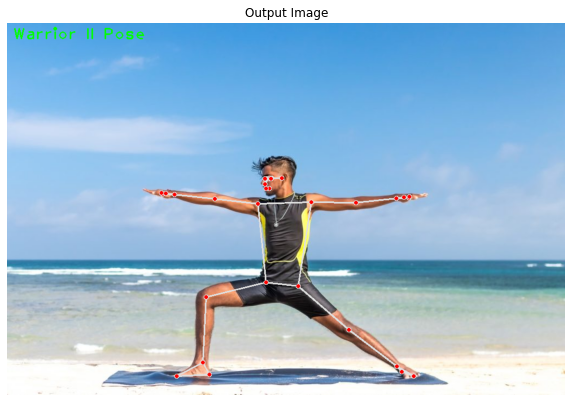

In [14]:
image = cv2.imread('./warriorIIpose.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

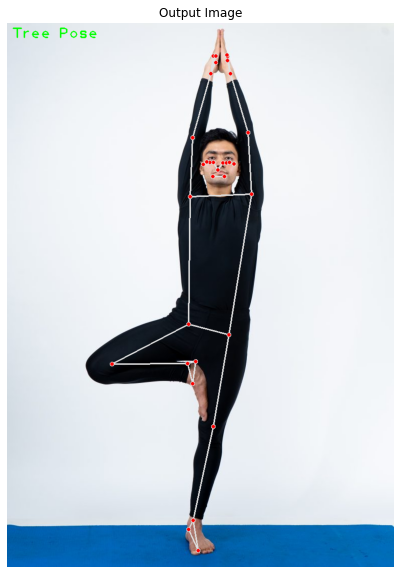

In [15]:
image = cv2.imread('./treepose.jpg')
output_image, landmarks = detectPose(image, mp_pose.Pose(static_image_mode=True,
                                         min_detection_confidence=0.5, model_complexity=0), display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

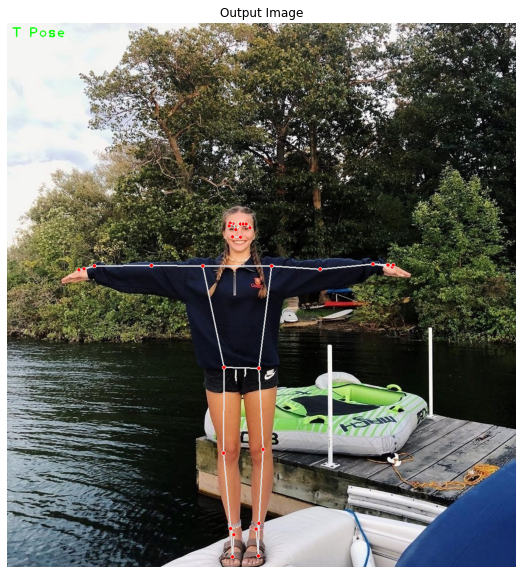

In [16]:
image = cv2.imread('./Tpose1.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

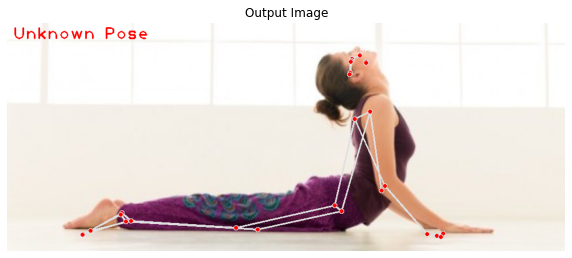

In [17]:
image = cv2.imread('./cobrapose1.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

In [13]:
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

cap = cv2.VideoCapture(0)

cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

while cap.isOpened():
    
    ok, frame = cap.read()
    
    if not ok:
        
        continue
    
    frame = cv2.flip(frame, 1)
    
    frame_height, frame_width, _ =  frame.shape
    
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    frame, landmarks = detectPose(frame, pose_video, display=False)
    
    if landmarks:
        
        frame, _ = classifyPose(landmarks, frame, display=False)
    
    cv2.imshow('Pose Classification', frame)

    key = cv2.waitKey(1) & 0xFF
    
    if key == ord("q"):
        
        break

cap.release()
cv2.destroyAllWindows()